In [1]:
import numpy as np
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline
import time
import cv2
import random
from model_basic import *
from image import ImageDataGenerator
import os

from keras.models import Sequential
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.optimizers import RMSprop, Adadelta
from keras.layers.convolutional import Convolution2D,UpSampling2D
from keras.layers.core import Dense, Activation, TimeDistributedDense, Dropout, Reshape, Flatten

from keras.layers.wrappers import TimeDistributed
from keras.models import model_from_json


print 'All libs successfully loaded!'

Using Theano backend.
Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


All libs successfully loaded!


In [2]:
# path to data
path2set="../dcom/TrainingSet/"
path2numpy = path2set+"numpy/"
path2nfolds=path2numpy+'nfolds/'
foldnm=1

In [3]:
# load data
def load_data(path):
    print ('_' *50)
    print 'please wait to load data ...'
    start_time=time.time()
    tmp = np.load(path)
    X=tmp['X']
    Y=tmp['Y'] 
    print ('X shape: ', X.shape)
    print ('Y shape: ',Y.shape)
    print ('Min and Max X: ', np.min(X), np.max(X))
    print ('Min and Max Y: ', np.min(Y), np.max(Y))
    elapsed_time=time.time()-start_time
    print 'Elapsed time: %d seconds' % elapsed_time
    print ('_' *50)
    return X,Y

def grays_to_RGB(img):
    # turn 2D grayscale image into grayscale RGB
    return np.dstack((img, img, img))

def image_with_mask(img, mask):
    maximg=np.max(img)
    mask=np.asarray(mask,dtype='uint8')
    if np.max(mask)<=1:
        mask=mask*255
    # returns a copy of the image with edges of the mask added in red
    img_color = grays_to_RGB(img)
    mask_edges = cv2.Canny(mask, 100, 200) > 0
    #print np.sum(mask_edges)
    img_color[mask_edges, 0] = maximg  # set channel 0 to bright red, green & blue channels to 0
    img_color[mask_edges, 1] = 0
    img_color[mask_edges, 2] = 0
    img_color=img_color/float(np.max(img))
    return img_color

# 5D array image display
def disp_img_mask(img,mask=None,ind=None):
    # img and mask are 5d arrays, N*time*C*H*W
    img=np.squeeze(img)
    
    # check for random dispaly or based on input
    if ind is None:
        n1=np.random.randint(img.shape[0])
    else:
        n1=ind
        
    I1=img[n1,:]
    print I1.shape
    
    if mask is None:
        M1=np.zeros(I1.shape,dtype='uint8')
    else:
        mask=np.squeeze(mask)
        M1=mask[n1,:]
    print M1.shape
    
    r,c=2,5
    for k in range(r*c):
        plt.subplot(r,c,k+1)
        imgmask=image_with_mask(I1[k,:],M1[k,:])
        plt.imshow(imgmask)
        plt.title('s: %s, maxI: %s' %(n1,np.max(I1[k,:])))
    plt.show()
        
# preprocess
def preprocess(X,Y,param_prep):
    
    # get params
    h=param_prep['img_rows']
    w=param_prep['img_cols']    
    crop=param_prep['crop']
    imr=param_prep['resize_factor'] # image resize
    norm_ena=param_prep['norm_ena'] # normalization 
    
    print ('_' *50)
    start_time=time.time()
    Y=np.asarray(Y,dtype='uint8')
    # center crop h*w
    if crop is 'center':
        H,W=X.shape[2:]
        hc=(H-h)/2
        wc=(W-w)/2
        X=X[:,:,hc:H-hc,wc:W-wc]
        Y = Y[:,:,hc:H-hc,wc:W-wc]
    elif crop is 'random':
        H,W=X.shape[2:]
        hc=(H-h)/2
        wc=(W-w)/2
        hcr=np.random.randint(hc)
        wcr=np.random.randint(wc)
        X=X[:,:,hc:H-hc,wc:W-wc]
        Y = Y[:,:,hc:H-hc,wc:W-wc]
        
    print ('X shape: ', X.shape)
    print ('Y shape: ',Y.shape)

    print 'please wait to resize images ...'
    if imr<1:
        img_h=int(X.shape[2]*imr) # rows
        img_w=int(X.shape[3]*imr) # columns
        X_r=np.zeros([X.shape[0],1,img_h,img_w],dtype=X.dtype)
        Y_r=np.zeros([Y.shape[0],1,img_h,img_w],dtype=Y.dtype)
        for k1 in range(len(X)):
            X_r[k1, 0] = cv2.resize(X[k1, 0], (img_w, img_h), interpolation=cv2.INTER_CUBIC)
            Y_r[k1, 0] = cv2.resize(Y[k1, 0], (img_w, img_h), interpolation=cv2.INTER_CUBIC)
    else:
        X_r=X
        Y_r=Y
    
    # normalization
    if norm_ena is True:
        X_r=np.array(X_r,dtype='float32')
        for k in range(X_r.shape[0]):
            for m in range(X_r.shape[1]):
                mean = np.mean(X_r[k,m,0])  # mean       
                sigma = np.std(X_r[k,m,0])  # std
                if sigma<1e-5:
                    sigma=1
                X_r[k,m,:,:] = X_r[k,m,:,:]-mean
                X_r[k,m,:,:] = X_r[k,m,:,:]/ sigma

    print ('X_r size: ', X_r.shape)
    print ('Y_r size: ',Y_r.shape)
    print ('Min and Max  X_r: ', np.min(X_r), np.max(X_r))
    print ('Min and Max  Y_r: ',  np.min(Y_r),  np.max(Y_r))        
        
    # add time dimension
    X_r=np.expand_dims(X_r,axis=2)
    Y_r=np.expand_dims(Y_r,axis=2)
    
    print ('X_r size: ', X_r.shape)
    print ('Y_r size: ',Y_r.shape)
    print ('Min and Max  X_r: ', np.min(X_r), np.max(X_r))
    print ('Min and Max  Y_r: ',  np.min(Y_r),  np.max(Y_r))

    elapsed_time=time.time()-start_time
    print 'Elapsed time: %d seconds' % elapsed_time
    print ('_' *50)
    return X_r,Y_r

# convert mask to volumes
def mask2volume(Y,h=1):
    
    # number of dataset
    N1=Y.shape[0]
    
    # number of slices
    N2=Y.shape[1]
    
    V=np.zeros(N1)
    for k in range(N1):
        Vz=0
        for z in range(N2-1):
            Yz=Y[k,z,:]
            Yzp1=Y[k,z+1,:]
            Az=np.sum(Yz)
            Azp1=np.sum(Yzp1)
            Vz=Vz+.5*(Az+Azp1)
        V[k]=Vz*h            
    
    Vn=V/np.max(V)
    return V,Vn

# random data generator
datagen = ImageDataGenerator(featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=75,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.0,
        zoom_range=0,
        channel_shift_range=0.0,
        fill_mode='nearest',
        cval=0.0,
        horizontal_flip=True,
        vertical_flip=True,
        dim_ordering='th')
        
def iterate_minibatches(inputs1 , targets,  batchsize, shuffle=False, augment=True):
    assert len(inputs1) == len(targets)
 
    if shuffle is True:
        indices = np.arange(len(inputs1))
        np.random.shuffle(indices)
        print 'shuffled!'
    for start_idx in range(0, len(inputs1) - batchsize + 1, batchsize):
        if shuffle is True:
            excerpt = indices[start_idx:start_idx + batchsize]
            print 'shuffled!'
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        x = inputs1[excerpt]
        y = targets[excerpt] 
        for  xxt,yyt in datagen.flow(x, y , batch_size=x.shape[0]):
            x = xxt.astype(np.float32) 
            y = yyt 
            break

    #yield x, np.array(y, dtype=np.uint8)         
    return x, np.array(y, dtype=np.uint8)         



In [4]:
# load train data
X_train,Y_train=load_data(path2nfolds + 'trainfold'+str(foldnm)+'.npz')

# load test data
X_test,Y_test=load_data(path2nfolds + 'testfold'+str(foldnm)+'.npz')


__________________________________________________
please wait to load data ...
('X shape: ', (24, 10, 256, 216))
('Y shape: ', (24, 10, 256, 216))
('Min and Max X: ', 0, 1197)
('Min and Max Y: ', False, True)
Elapsed time: 0 seconds
__________________________________________________
__________________________________________________
please wait to load data ...
('X shape: ', (8, 10, 256, 216))
('Y shape: ', (8, 10, 256, 216))
('Min and Max X: ', 0, 1060)
('Min and Max Y: ', False, True)
Elapsed time: 0 seconds
__________________________________________________


(10, 256, 216)
(10, 256, 216)


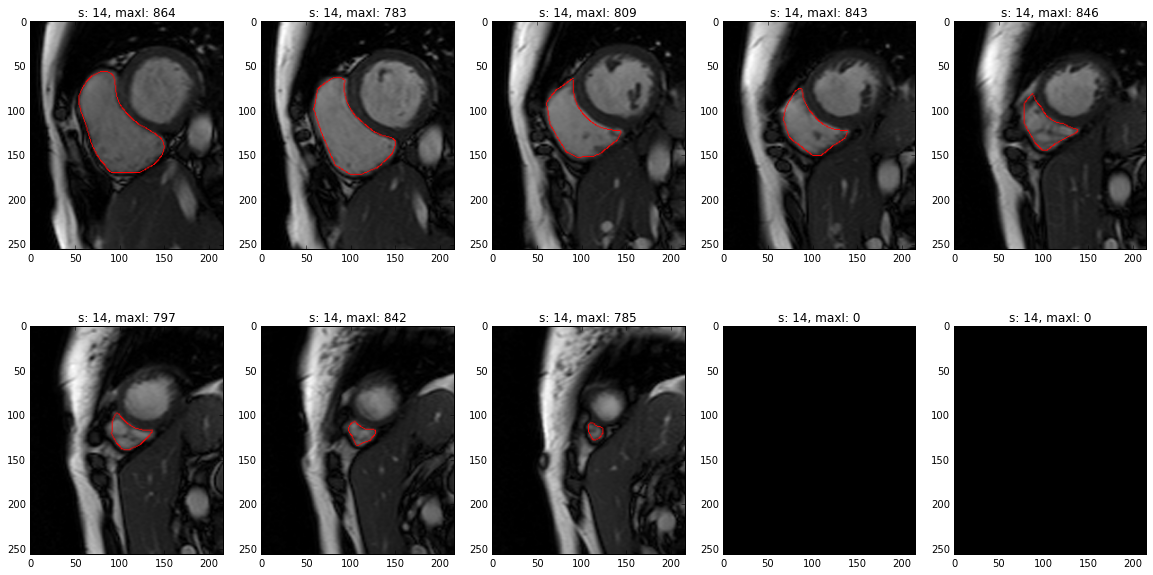

In [5]:
# display sample image
plt.figure(figsize=(20,10)) 
disp_img_mask(X_train,Y_train)

In [6]:
# pre-processing 

param_prep={
    'img_rows': 192,
    'img_cols': 192,
    'crop'    : 'center',
    'resize_factor': 1,
    'norm_ena' : True,
}

# preprocess train data
X_train_r,Y_train_r=preprocess(X_train,Y_train,param_prep)

# preprocess test data
X_test_r,Y_test_r=preprocess(X_test,Y_test,param_prep)

__________________________________________________
('X shape: ', (24, 10, 192, 192))
('Y shape: ', (24, 10, 192, 192))
please wait to resize images ...
('X_r size: ', (24, 10, 192, 192))
('Y_r size: ', (24, 10, 192, 192))
('Min and Max  X_r: ', -1.4170325, 19.443384)
('Min and Max  Y_r: ', 0, 1)
('X_r size: ', (24, 10, 1, 192, 192))
('Y_r size: ', (24, 10, 1, 192, 192))
('Min and Max  X_r: ', -1.4170325, 19.443384)
('Min and Max  Y_r: ', 0, 1)
Elapsed time: 0 seconds
__________________________________________________
__________________________________________________
('X shape: ', (8, 10, 192, 192))
('Y shape: ', (8, 10, 192, 192))
please wait to resize images ...
('X_r size: ', (8, 10, 192, 192))
('Y_r size: ', (8, 10, 192, 192))
('Min and Max  X_r: ', -2.5976481, 185.71657)
('Min and Max  Y_r: ', 0, 1)
('X_r size: ', (8, 10, 1, 192, 192))
('Y_r size: ', (8, 10, 1, 192, 192))
('Min and Max  X_r: ', -2.5976481, 185.71657)
('Min and Max  Y_r: ', 0, 1)
Elapsed time: 0 seconds
___________

(10, 192, 192)
(10, 192, 192)


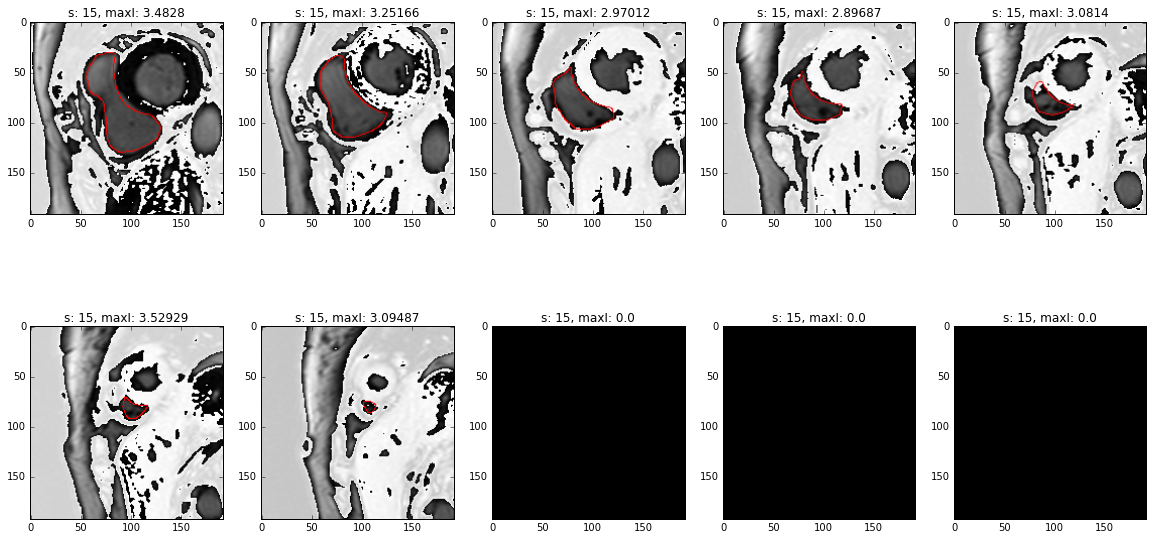

(10, 192, 192)
(10, 192, 192)


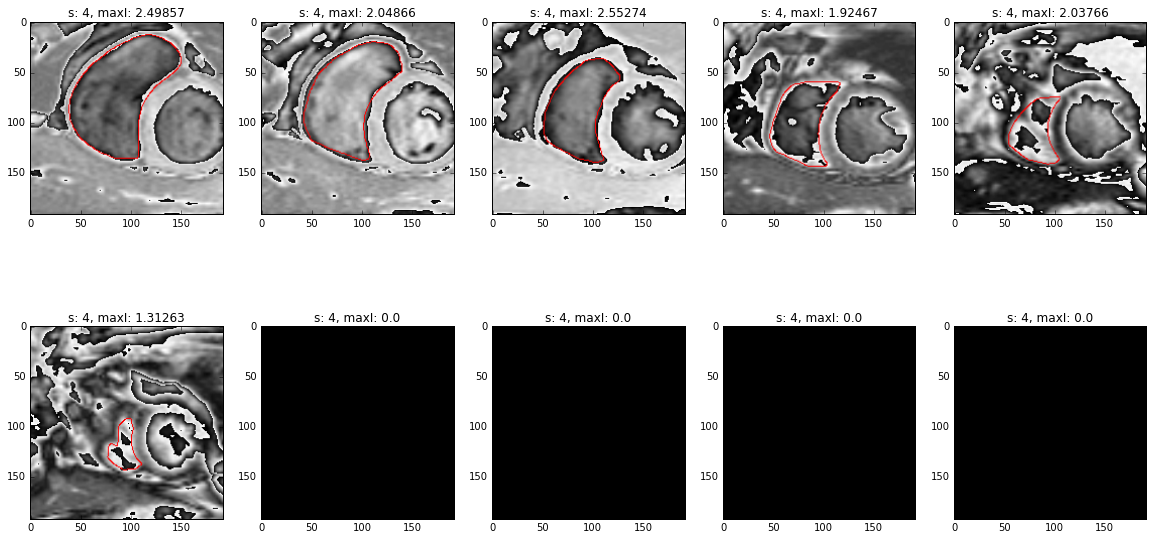

In [7]:
# display sample image
plt.figure(figsize=(20,10)) 
disp_img_mask(X_train_r,Y_train_r)

plt.figure(figsize=(20,10)) 
disp_img_mask(X_test_r,Y_test_r)

In [10]:

# define some run parameters
batch_size      = 1
nb_epochs       = 20
examplesPer     = X_train_r.shape[0]
timestep        = X_train_r.shape[1]
hidden_units    = 200
h,w= X_train_r.shape[3:5]

#define our time-distributed setup
model = Sequential()

model.add(TimeDistributed(Convolution2D(16, 3, 3, border_mode='same',activation='relu'), input_shape=(timestep,1,h,w)))
model.add(TimeDistributed(Convolution2D(16, 3, 3, border_mode='same',activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2),border_mode='same')))
print 'output: ', model.output_shape

model.add(TimeDistributed(Convolution2D(32, 3, 3, border_mode='same',activation='relu')))
model.add(TimeDistributed(Convolution2D(32, 3, 3, border_mode='same',activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2),border_mode='valid')))
print 'output: ', model.output_shape

model.add(TimeDistributed(Convolution2D(64, 3, 3, border_mode='same',activation='relu')))
model.add(TimeDistributed(Convolution2D(64, 3, 3, border_mode='same',activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2),border_mode='same')))
print 'output: ', model.output_shape

model.add(TimeDistributed(Convolution2D(128, 3, 3, border_mode='same',activation='relu')))
model.add(TimeDistributed(Convolution2D(128, 3, 3, border_mode='same',activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2),border_mode='same')))
print 'output: ', model.output_shape

model.add(TimeDistributed(Convolution2D(256, 3, 3, border_mode='same',activation='relu')))
model.add(TimeDistributed(Convolution2D(256, 3, 3, border_mode='same',activation='relu')))
print 'output: ', model.output_shape

model.add(TimeDistributed(Flatten()))
print 'output: ', model.output_shape
model.add(Activation('relu'))
model.add(GRU(output_dim=144,return_sequences=False))
print 'output: ', model.output_shape

model.add(Reshape((12, 12)))
print 'output: ', model.output_shape

#model.add((UpSampling2D(size=(2, 2))))
model.add(TimeDistributed(UpSampling2D(size=(2, 2))))
#model.add(Convolution2D(128, 3, 3, border_mode='same',activation='relu'))
print 'output: ', model.output_shape

#model.add(TimeDistributed(UpSampling2D(size=(2, 2))))
#model.add(TimeDistributed(Convolution2D(64, 3, 3, border_mode='same',activation='relu')))

#model.add(TimeDistributed(UpSampling2D(size=(2, 2))))
#model.add(TimeDistributed(Convolution2D(32, 3, 3, border_mode='same',activation='relu')))

#model.add(TimeDistributed(UpSampling2D(size=(2, 2))))
#model.add(TimeDistributed(Convolution2D(16, 3, 3, border_mode='same',activation='relu')))

#model.add(Convolution2D(1, 1, 1, border_mode='same',activation='relu'))

rmsprop = RMSprop()
model.compile(loss='binary_cross_entropy', optimizer=rmsprop)
model.summary()


output:  (None, 10, 16, 96, 96)
output:  (None, 10, 32, 48, 48)
output:  (None, 10, 64, 24, 24)
output:  (None, 10, 128, 12, 12)
output:  (None, 10, 256, 12, 12)
output:  (None, 10, 36864)
output:  (None, 144)
output:  (None, 12, 12)


ValueError: Axis should not exceed x.ndim-1.

In [ ]:
print 'train in progress ...'

if  not os.path.exists('./output/weights'):
    os.makedirs('./output/weights')
    print 'weights folder created'
filepath="./output/weights/fold"+str(foldnm)+"-volume_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only='True',mode='min')


param_prep={
    'img_rows': 192,
    'img_cols': 192,
    'crop'    : 'center',
    'resize_factor': 1,
    'norm_ena' : True,
}


# Fit the model
# number of epochs
nb_epoch=500
start_time=time.time()
score_train=[]
score_test=[]

for epoch in range(nb_epoch):
    print '-'*50
    print 'epoch: %s' %epoch
    seed = np.random.randint(0, 999999)

    # augment training
    Xaug,Yaug=iterate_minibatches( X_train, Y_train , X_train.shape[0], shuffle=False)
    X_train_aug,Y_train_aug=preprocess(Xaug,Yaug,param_prep)
    _,y_train_aug=mask2volume(Y_train_aug)
    #X_train_aug=X_train_r
    #disp_img_mask(X_train_aug,Y_train_aug)
    
    model.fit(X_train_aug, y_train_aug, validation_data=(X_test_r, y_test),nb_epoch=1, batch_size=1,verbose=0,shuffle=True,callbacks=[checkpoint])
    
    s_train=model.evaluate(X_train_aug, y_train,verbose=0)
    s_test=model.evaluate(X_test_r, y_test,verbose=0)
    print 'train: %.5f' %s_train    
    print 'test: %.5f' %s_test

    score_train=np.append(score_train,s_train)
    score_test=np.append(score_test,s_test)    

plt.plot(score_train)
plt.plot(score_test)


In [ ]:
weights_path="./output/weights/fold"+str(foldnm)+"-volume_weights.hdf5"
print weights_path
model.load_weights(weights_path)

s_train=model.evaluate(X_train_aug, y_train_aug,verbose=0)
s_test=model.evaluate(X_test_r, y_test,verbose=0)
print 'train: %.5f' %s_train    
print 'test: %.5f' %s_test

y_pred1=model.predict(X_train_aug)
#y_pred1=np.reshape(y_pred1,(1,y_pred1.shape[0]))
y_pred2=model.predict(X_test_r)
v_train,_=mask2volume(Y_train_aug)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(v_train)
y_pred1=np.max(v_train)*y_pred1
plt.plot(y_pred1)
plt.title('train')

plt.subplot(1,2,2)
v_test,_=mask2volume(Y_test)
y_pred2=np.max(v_test)*y_pred2
plt.plot(v_test)
plt.plot(y_pred2)
plt.title('test')
plt.legend('ground truth','automatic',loc='upper right')
plt.show()

In [ ]:
xaug,yaug=iterate_minibatches( X_train, Y_train , X_train.shape[0], shuffle=False)
Xaug,Yaug=preprocess(xaug,yaug,param_prep)
print np.max(xaug)
# display sample image
plt.figure(figsize=(20,10)) 
disp_img_mask(Xaug,Yaug)

vaug,vaugn=mask2volume(Yaug)
print vaug,vaugn